In [2]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [3]:
import os
import h5py
import numpy as np
import time
import pandas as pd

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count, plot_images
from IPython.display import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from cryoem.conversions import d_q, euler2quaternion
#from cryoem.distance_estimation import train_siamese
import ipyvolume as ipv
from collections import Counter
import itertools
import seaborn as sns; sns.set(style="whitegrid", color_codes=True)
import io

In [4]:
# tf.debugging.set_log_device_placement(True)

In [5]:
tf.__version__

'2.1.0'

In [6]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16535636073988217602
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16594373360736990200
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16150108023536538992
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11322146816
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 9984183069627104742
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:86:00.0, compute capability: 3.5"
]


In [7]:
PROTEIN="5j0n"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [8]:
# location of *.h5 files
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [9]:
projections = data['Projections']
projections.shape

(5000, 116, 116)

In [10]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

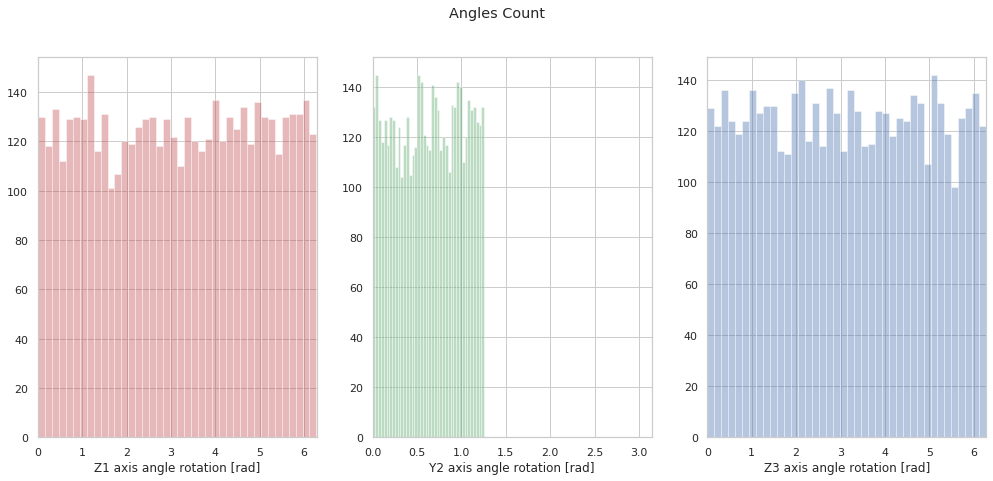

In [11]:
plot_angles_count(angles_true)

In [12]:
from cryoem.distance_estimation import global_standardization

In [13]:
X, y = np.array(projections, dtype=np.float32), np.array(angles_true, dtype=np.float32)

In [14]:
X = global_standardization(X)

Image shape: (116, 116)
Data Type: float32
***
Mean: 0.262 | Std: 1.046
Min:  0.000 | Max: 15.458
Mean: 0.000 | Std: 1.000
Min:  -0.250 | Max: 14.526


In [15]:
channels = "gray"
if channels == "rgb":
    X = np.stack((X,)*3, axis=-1)
elif channels == "gray":
    X = X[:,:,:,np.newaxis]

---

## Angle Recovery: Estimated Distance FULL

In [16]:
model_filename = "training/noisy_var0.h5"

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

In [17]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ

In [18]:
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=512)

In [19]:
batch_size = 1024
idx1 = list(np.random.choice(range(5000), size=batch_size))
idx2 = list(np.random.choice(range(5000), size=batch_size))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

<Figure size 432x288 with 0 Axes>

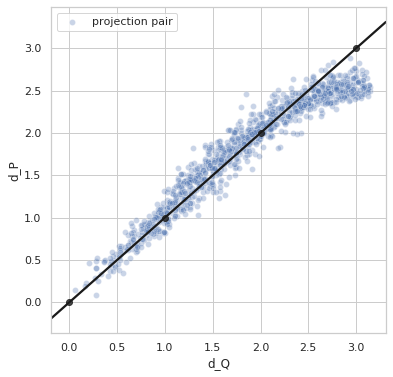

<Figure size 432x288 with 0 Axes>

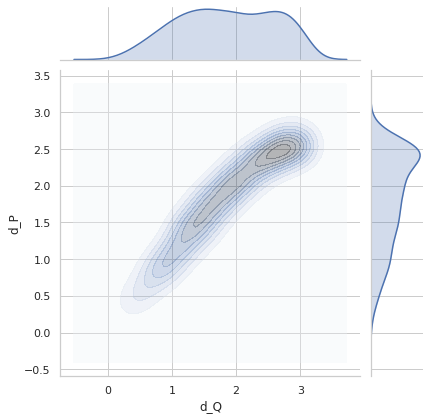

Variance = 0.21339263031056177
Min. angle recovery loss possible = 0.04549194551590808


In [20]:
plot_dP_dQ(dP_values, dQ_values);

#### Angle Recovery

In [20]:
# https://www.tensorflow.org/tutorials/distribute/custom_training
# https://www.tensorflow.org/guide/distributed_training

In [21]:
# BUFFER_SIZE = len(train_images)

# BATCH_SIZE_PER_REPLICA = 64
# GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

# EPOCHS = 10

# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(BUFFER_SIZE).batch(GLOBAL_BATCH_SIZE) 
# test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(GLOBAL_BATCH_SIZE) 

# train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)
# test_dist_dataset = strategy.experimental_distribute_dataset(test_dataset)

In [22]:
# with strategy.scope():
#     optimizer = tf.keras.optimizers.Adam()
    
#     loss_object = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
    
#     def compute_loss(q1_predicted, q2_predicted, distance_target):
#         per_example_loss = loss_object(distance_target, d_q(q1_predicted, q2_predicted))
#         return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)


#     def train_step(inputs):
#         in1, in2 = inputs

#         with tf.GradientTape() as tape:
#             #predictions = model(images, training=True)
#             #loss = compute_loss(labels, predictions)
#             loss_value = compute_loss(q1_predicted, q2_predicted, distance_fn(in1, in2))
#         gradients = tape.gradient(loss_value, q1_predicted + q2_predicted)
#         #gradients = tape.gradient(loss, model.trainable_variables)
#         #optimizer.apply_gradients(zip(gradients, model.trainable_variables))
#         optimizer.apply_gradients(zip(gradients, q1_predicted + q2_predicted))
#         return loss 

#     @tf.function
#     def distributed_train_step(dataset_inputs):
#         per_replica_losses = strategy.run(train_step, args=(dataset_inputs,))
#         return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)


#     for epoch in range(EPOCHS):
#         # TRAIN LOOP
#         total_loss = 0.0
#         num_batches = 0
#         for x in train_dist_dataset:
#             total_loss += distributed_train_step(x)
#             num_batches += 1
#         train_loss = total_loss / num_batches



In [21]:


# QUATERNION VARIABLE
import time
import numpy as np
from IPython import display as IPyDisplay
from tensorflow.keras.optimizers import Adam
import seaborn as sns; sns.set(style="whitegrid", color_codes=True)
from tensorflow_graphics.geometry.transformation import quaternion
from cryoem.conversions import euler2quaternion, d_q, quaternion2euler
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# strategy = tf.distribute.StrategyExtended()  #MirroredStrategy()
# with strategy.scope():



def angles_transpose(angles):
    angles = angles.copy()
    cols = [2, 1, 0]
    idx = np.empty_like(cols)
    idx[cols] = np.arange(len(cols))
    angles[:] = -angles[:, idx]
    return angles


def train_angle_recovery(steps, 
                         batch_size, 
                         in_data, 
                         distance_fn, 
                         file_name,
                         q_predicted=None,
                         angles_true=None,
                         learning_rate=0.01): 

    time_start = time.time()
    collect_data = []
    optimizer = Adam(learning_rate=learning_rate)

    low_ang = [0.0*np.pi, 0.0*np.pi, 0.0*np.pi]
    high_ang = [2.0*np.pi, 0.4*np.pi, 2.0*np.pi]            
    euler = np.random.uniform(low=[low_ang[0], low_ang[1], low_ang[2]], 
                          high=[high_ang[0], high_ang[1], high_ang[2]],
                          size=(len(in_data), 3))
    
    if q_predicted:
        # continue where left off
        q_predicted = [tf.Variable(q) for q in q_predicted]
    else:
        # optimize from scratch
        q_predicted = [tf.Variable(q) for q in euler2quaternion(euler)]

    if in_data.shape[1] == 3:
        in_data = euler2quaternion(in_data)

    losses = np.empty(steps)
    report = f"Shape of projections: {in_data.shape}"
    found_minimizer = False

    print(time.time()-time_start)

    for step, idx1, idx2 in sample_iter(steps, range(len(in_data)), batch_size, style="random"):
        q1 = [q_predicted[i] for i in idx1]
        q2 = [q_predicted[i] for i in idx2]


        # Compute distances
        in1 = [in_data[i] for i in idx1]
        in2 = [in_data[i] for i in idx2]


        distance_target = distance_fn(in1, in2)

        # WORK ONLY WITH SMALL DISTANCES (<2.5)
        q1 = np.array(q1)
        q2 = np.array(q2)
        in1 = np.array(in1)
        in2 = np.array(in2)
        indices_le2 = np.where(distance_target<2.5)[0]
        distance_target = np.take(distance_target, indices_le2)
        q1 = list(np.take(q1, indices_le2))
        q2 = list(np.take(q2, indices_le2))
        in1 = list(np.take(in1, indices_le2))
        in2 = list(np.take(in2, indices_le2))

        # Optimize by gradient descent.
        losses[step-1], gradients = gradient(q1, q2, distance_target)
        optimizer.apply_gradients(zip(gradients, q1 + q2))

        # Visualize progress periodically
        if step % 10 == 0:
            a = np.zeros((len(q_predicted), 4))
            for i, e in enumerate(q_predicted):
                a[i] = e.numpy()
            collect_data.append(a)

            if angles_true is not None:
                fig, axs = plt.subplots(1, 3, figsize=(24,7))

                # Optimization loss subplot
                axs[0].plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
                axs[0].set_xlabel('time [s]')
                axs[0].set_ylabel('loss');
                axs[0].set_title(f"[{step}/{steps}] Angle recovery optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")

                # NT - Distance count subplot (full)
                d2 = d_q(R.from_euler('zyz', angles_true).as_quat(), q_predicted)
                axs[1].set_xlim(0, np.pi)
                axs[1].set_title(f"[{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
                s = sns.distplot(d2, kde=False, bins=100, ax=axs[1], axlabel="Distance [rad]", color="r")
                max_count = int(max([h.get_height() for h in s.patches]))
                axs[1].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

                # T - Distance count subplot (full)
                angles_true_T = angles_transpose(angles_true)
                d2 = d_q(R.from_euler('zyz', angles_true_T).as_quat(), q_predicted)
                axs[2].set_xlim(0, np.pi)
                axs[2].set_title(f"[{step}/{steps}] TRANSPOSED Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
                s = sns.distplot(d2, kde=False, bins=100, ax=axs[2], axlabel="Distance [rad]", color="r")
                max_count = int(max([h.get_height() for h in s.patches]))
                axs[2].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
            else:
                fig, axs = plt.subplots(figsize=(10,7))

                # Optimization loss subplot
                axs.plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
                axs.set_xlabel('time [s]')
                axs.set_ylabel('loss');
                axs.set_title(f"[{step}/{steps}] Angle recovery optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")


            IPyDisplay.clear_output(wait=True)
            IPyDisplay.display(plt.gcf())
            plt.close();
            time.sleep(0.1)

            np.savez(file_name, quaternion.normalize(q_predicted).numpy(), losses, np.array(collect_data))

            if found_minimizer:
                time_elapsed = time.time() - time_start
                report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}\n'
                break;

        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time.time() - time_start
            report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}\n'

        if step >= 1001 and np.mean(losses[step-1001:step-1]) < 1e-8:
            found_minimizer = True

        if step >= 2001 and np.abs(np.mean(losses[step-1000:step-1])-np.mean(losses[step-2000:step-1000])) < 1e-7:
            found_minimizer = True

    print(report)
    return quaternion.normalize(q_predicted).numpy(), losses, np.array(collect_data)

def sample_iter(steps, projection_idx, num_pairs, style="random", k=None):

    for step in range(1, steps+1):
        if not k and style != "random":
            raise ValueError("Please specify k for kNN for sample_pairs method")

        if style=="random":
            idx1 = list(np.random.choice(projection_idx, size=num_pairs))
            idx2 = list(np.random.choice(projection_idx, size=num_pairs))

        elif style=="knn":
            idx1 = list(np.random.choice(projection_idx, size=num_pairs))
            indices_p, distances_p, A_p = get_knn_projections(k=k)
            idx2 = [indices_p[i][np.random.randint(1, k)] for i in idx1]

        elif style=="knn_and_random":
            # select random sample for the first element of pair
            idx1 = list(np.random.choice(projection_idx, size=num_pairs))

            # half from kNN
            indices_p, distances_p, A_p = get_knn_projections(k=k)
            idx2_knn = [indices_p[i][np.random.randint(1, k)] for i in idx1[:num_pairs//2]]
            idx2_random = list(np.random.randint(0, num_projections, num_pairs//2))
            # half random
            idx2 = idx2_knn + idx2_random

        yield step, idx1, idx2

def loss(q1_predicted, q2_predicted, distance_target):
    # The mean doesn't depend on the batch size.
    return tf.reduce_mean(tf.pow((d_q(q1_predicted, q2_predicted) - distance_target), 2))

def gradient(q1_predicted, q2_predicted, distance_target):
    with tf.GradientTape() as tape:
        loss_value = loss(q1_predicted, q2_predicted, distance_target)
    gradient = tape.gradient(loss_value, q1_predicted + q2_predicted)

    return loss_value, gradient



In [24]:
# 1.5 sec per step for < 2
# 18 sec per step for < 2.5

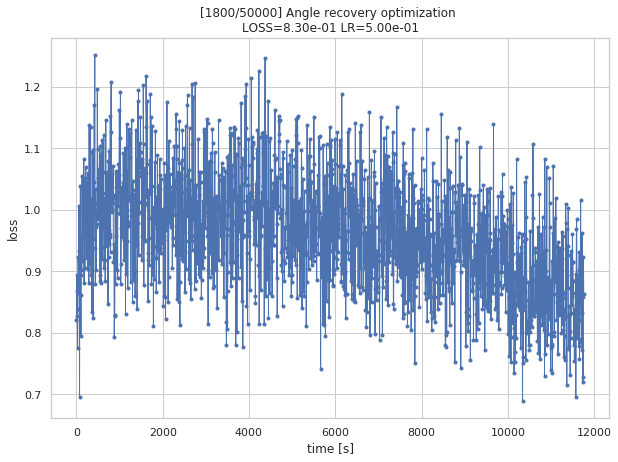

In [ ]:
q_predicted, losses, q_all = train_angle_recovery(steps=50000, 
                             batch_size=256, 
                             in_data=X, 
                             distance_fn=d_p, 
                             learning_rate=0.5, 
                             file_name="data/5j0n/angle_recovery_limited2.5_estimated_50k")

In [20]:
from cryoem.conversions import quaternion2euler

In [22]:
data = np.load("data/5j0n/angle_recovery_limited2.5_estimated_50k.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]


In [102]:
q_all.shape

(1547, 5000, 4)

In [103]:
# losses_filtered = losses[np.where(losses!=0)][::10]
# idx = np.argmin(losses_filtered)
# q_predicted = q_all[idx]
# losses_filtered.shape, idx, losses_filtered[idx],q_all[idx].shape

In [23]:
angles_predicted = quaternion2euler(q_predicted)

In [24]:
from cryoem.plots import plot_images

In [25]:
# plot_images(angles_predicted, projections, indices=range(100), img_size_scale=0.05)

In [ ]:
ipv.screenshot()

In [26]:
#np.save("data/5j0n/projections_limited2.5_estimated_50k", projections)
#np.save("data/5j0n/angles_true_limited2.5_estimated_50k", angles_true)
np.save("data/5j0n/angles_predicted_limited2.5_estimated_50k", angles_predicted)

In [27]:
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl

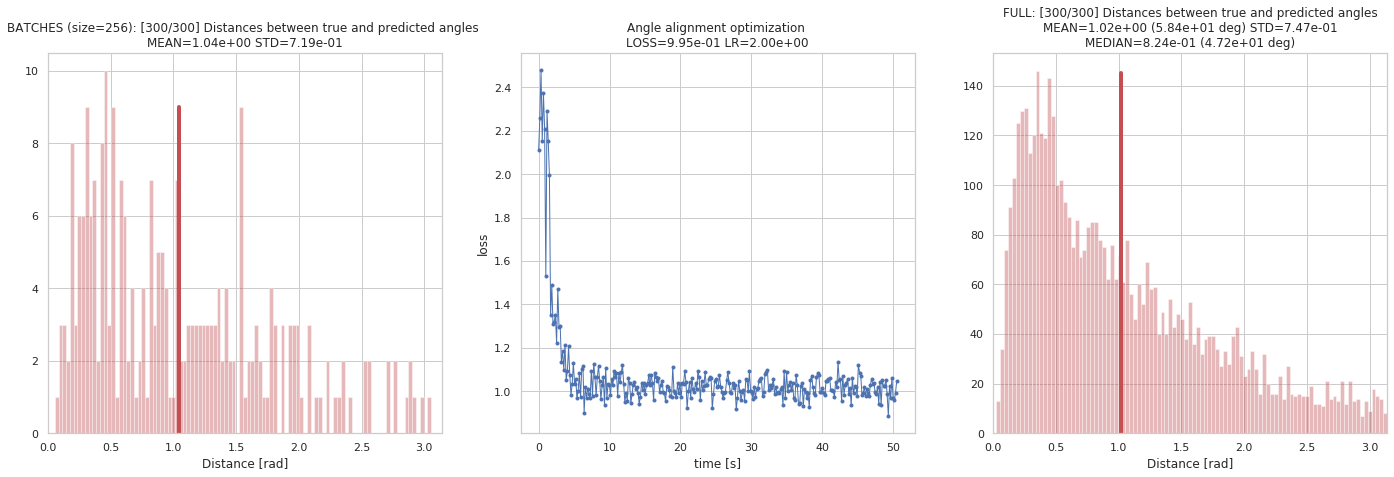

step 30/300 (7s): loss = 1.54e+00
step 60/300 (12s): loss = 1.03e+00
step 90/300 (17s): loss = 1.02e+00
step 120/300 (21s): loss = 1.02e+00
step 150/300 (27s): loss = 1.03e+00
step 180/300 (32s): loss = 1.01e+00
step 210/300 (37s): loss = 1.02e+00
step 240/300 (42s): loss = 1.01e+00
step 270/300 (47s): loss = 1.03e+00
step 300/300 (52s): loss = 1.00e+00



In [28]:
m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                        steps=300, 
                                                        batch_size=256, 
                                                        optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                        angles_true=angles_true, 
                                                        angles_predicted=angles_predicted)

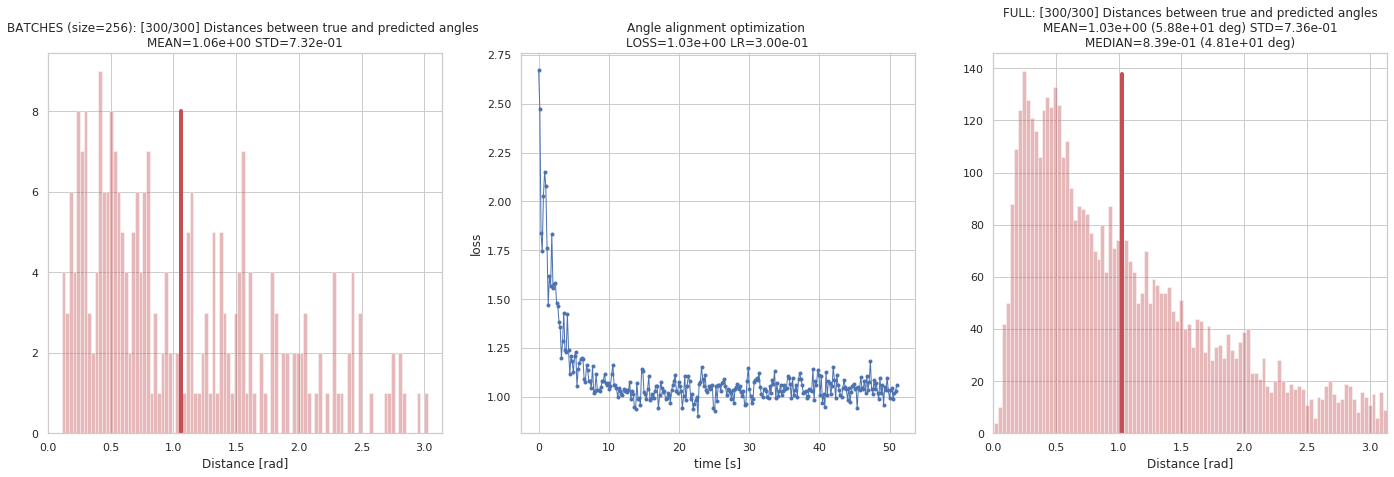

step 30/300 (5s): loss = 1.59e+00
step 60/300 (10s): loss = 1.10e+00
step 90/300 (15s): loss = 1.04e+00
step 120/300 (20s): loss = 1.03e+00
step 150/300 (25s): loss = 1.03e+00
step 180/300 (30s): loss = 1.03e+00
step 210/300 (35s): loss = 1.05e+00
step 240/300 (42s): loss = 1.05e+00
step 270/300 (47s): loss = 1.04e+00
step 300/300 (52s): loss = 1.05e+00



In [31]:
m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                        steps=300, 
                                                        batch_size=256, 
                                                        optimizer=Adam(learning_rate=0.3), 
                                                        angles_true=angles_true, 
                                                        angles_predicted=angles_predicted)

In [29]:
losses[-1]

0.9272336561730974

In [32]:
losses[-1]

0.9402966937452928

In [33]:
losses[-1]

0.8720905652363152

In [30]:
q_predicted_rotated =  update_quaternion(m, a_R, q_predicted)

angles_predicted_rotated = quaternion2euler(q_predicted_rotated)

np.save("data/5j0n/angles_predicted_rotated_limited2.5_estimated_50k", angles_predicted_rotated)